In [52]:
import numpy as np
import cv2, glob, os, re
import pandas as pd
import pylab as plt
from xml.etree import ElementTree as et
import pickle
%matplotlib inline

## 如果有畸变，则先生成undistort之后的图片

In [45]:
slices_img_path = r'D:\pic\tupian'  # 分段图放在这里
undistort_file = r'./jn_camera_all.pkl'   # 这个是相机参数pkl文件的路径

def undistort(img, col, undistort_file):
    '''
    恢复图像的径向畸变
    '''
    with open(undistort_file, 'rb') as f:
        distort_matrix = pickle.load(f)
    mtx, dist = distort_matrix["camera" +
                               col]["mtx"], distort_matrix["camera"+col]["dist"]
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

os.makedirs(r'./undistorted_slices', exist_ok = True)
for p in glob.glob(os.path.join(slices_img_path, '*H.jpg')):
    img = cv2.imread(p, 0)
    col = p.split('_')[-1][1]
    dst = undistort(img, col, undistort_file)
    cv2.imwrite(r'./undistorted_slices/%s' % os.path.basename(p), dst)

## 将图片整理成字典

In [46]:
pic_dict = {re.split('_', os.path.basename(k))[0]:{} for k in glob.glob(os.path.join(r'./undistorted_slices/', r'*H.jpg'))}
for p in glob.glob(os.path.join(r'./undistorted_slices/', r'*H.jpg')):
    pic_dict[re.split('_', os.path.basename(p))[0]][re.findall('([A-C]\d)H', p)[0]] = p
for k, v in pic_dict.copy().items():
    if len(v) != 12:
        pic_dict.pop(k)
        
print(len(pic_dict))

6


## 生成golden unit

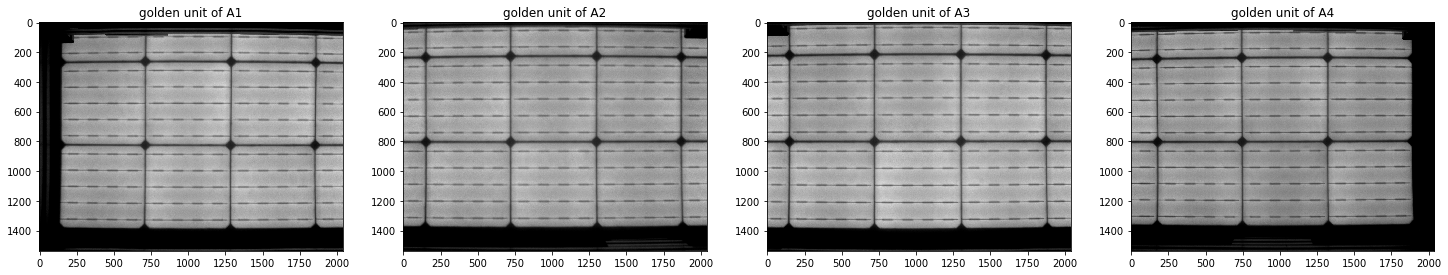

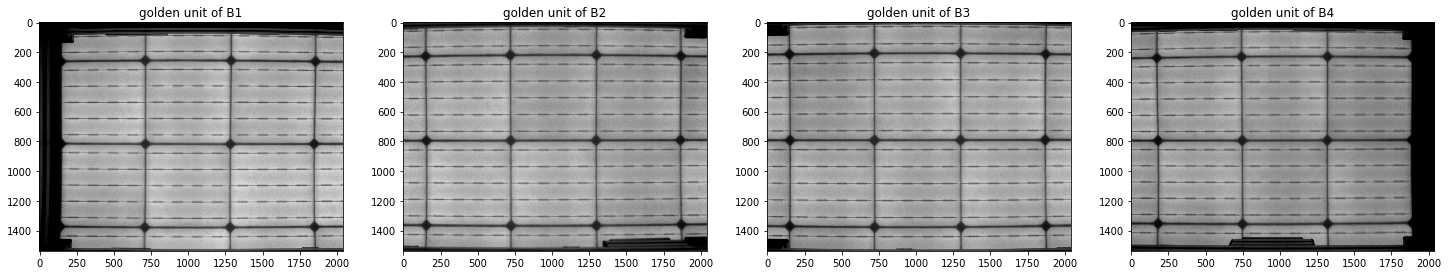

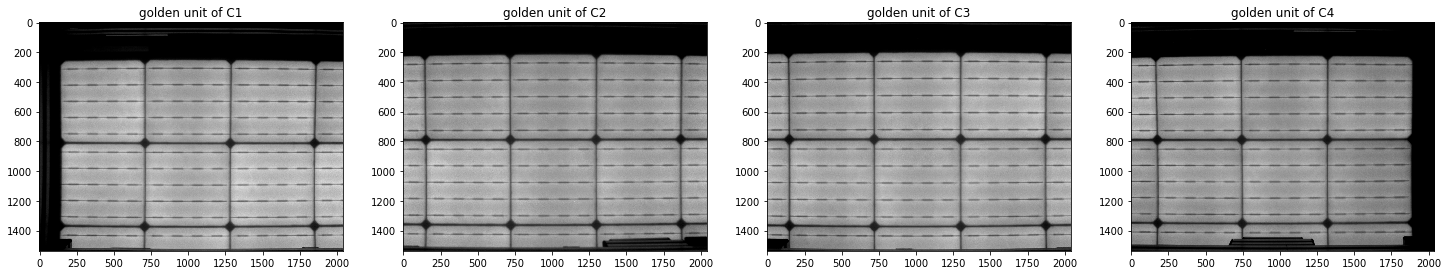

In [47]:
plt.rc('figure', figsize = (25, 8))
os.makedirs(r'./golden_units', exist_ok = True)
os.makedirs(r'./gu_label', exist_ok = True)
GOLDEN_UNIT_DICT = {}
for s in ['A', 'B', 'C']:
    for i in range(1,5):
        piece1 = []
        for v in pic_dict.values():
            piece1.append(cv2.imread(v['%s%i' % (s, i)], 0))
        piece1 = np.array(piece1)
        gu_piece1 = piece1.mean(0)
        GOLDEN_UNIT_DICT['%s%i' % (s, i)] = cv2.pyrDown(gu_piece1.astype(np.uint8))
        plt.subplot(1, 4, i)
        plt.title('golden unit of %s%i' % (s, i))
        plt.imshow(gu_piece1, 'gray')
        cv2.imwrite('./golden_units/jn_c_72_%s%i.jpg' % (s, i), gu_piece1)
        if i == 4:
            plt.show()

## 下一步：把Golden unit下载下来，打标签~
golden unit保存在ipynb所在文件夹的golden_units文件夹里面。<br>
**标签需知**：<br>
用labelimg打框，保证框的左上角点对齐角点位置。<br>
千万对齐不要打歪<br>

## 根据打的标签，生成golden_corners
把打好的标签上传上来。运行下面cell，观察一下是否点都是对的，以及数字是否是顺时针0123的顺序。

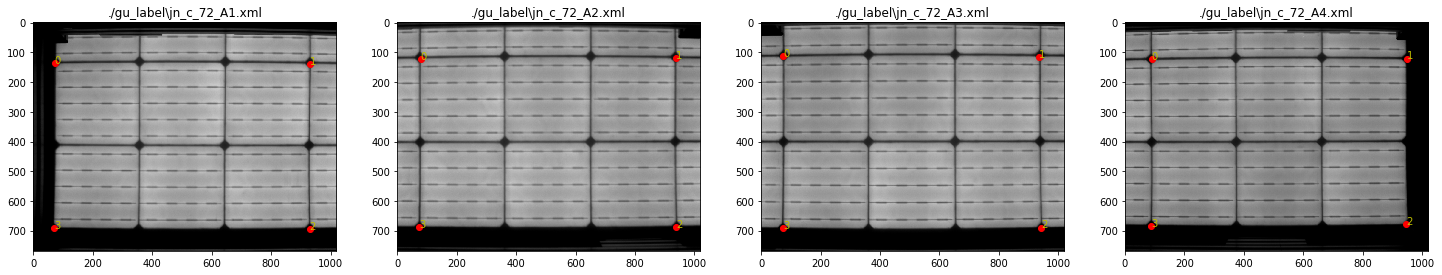

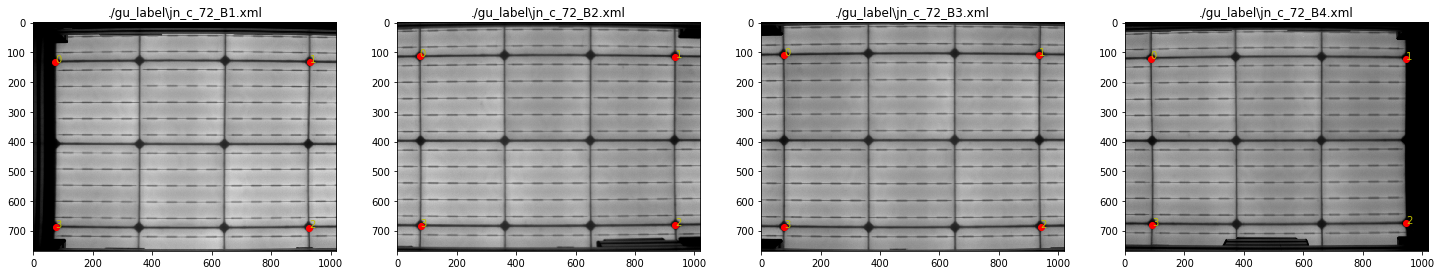

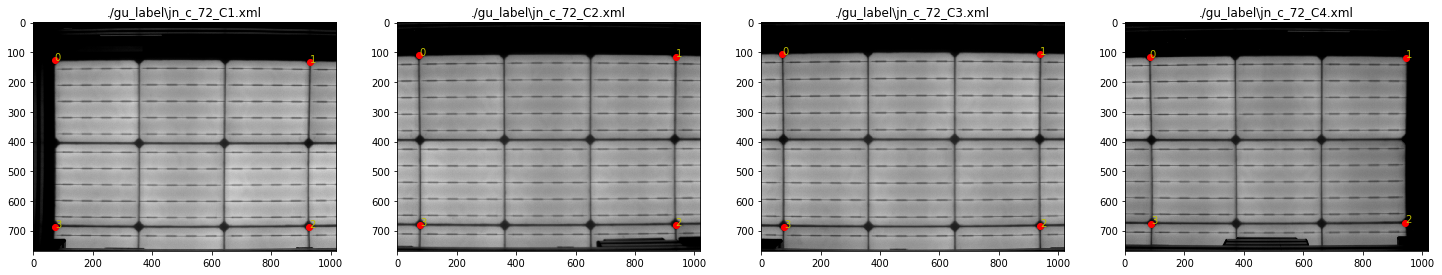

In [48]:
#get corners
def parse_objs_from_xml(xml_file):
    with open(xml_file) as f:
        tree = et.parse(f)
        root = tree.getroot()
    objs = []
    for o in tree.findall('object'):
        obj = {}
        obj['name'] = o.find('name').text
        obj['bndbox'] = []
        for pos in ['xmin', 'ymin', 'xmax', 'ymax']:
            obj['bndbox'].append(int(o.find('bndbox').find(pos).text))
        objs.append(obj)

    return objs

def reorg_dots(dots):
    dots = np.array(dots)
    sumxy = dots.sum(1)
    lt = dots[sumxy.argmin()]
    rd = dots[sumxy.argmax()]
    others = dots[np.argsort(sumxy)[1:-1]]
#     print(others)
    rt = others[others[:, 0].argmax()]
    ld = others[others[:, 0].argmin()]
    
    return np.array([lt, rt, rd, ld])

GOLDEN_CORNER_DICT = {}
k = 0
for xml in glob.glob(r'./gu_label/*.xml'):
    objs = parse_objs_from_xml(xml)
    img = cv2.imread(r'./golden_units//%s.jpg' % os.path.basename(xml).split('.')[0])
    plt.subplot(1, 4, k % 4 + 1)
    plt.imshow(cv2.pyrDown(img), 'gray')
    plt.title(xml)
    
    corners = np.array([obj['bndbox'][:2] for obj in objs])
    corners = reorg_dots(corners)
    corners = np.uint(corners / 2)
#     print(xml.split('.')[1])
    GOLDEN_CORNER_DICT['%s' % xml.split('.')[1][-2:]] = corners
    i = 0
    for x, y in corners:
#         plt.scatter(x, y, c = 'r')
        plt.annotate(str(i), xy = (x, y), color = 'y')
        i += 1
    xs, ys = corners.T
    plt.scatter(xs, ys, c = 'r')
    k += 1
    if k % 4 == 0:
        plt.show()

## 将GOLDEN_UNIT和GOLDEN_CORNER写入配置文件pkl

In [49]:
golden_parameters = {"GOLDEN_UNIT_DICT": GOLDEN_UNIT_DICT, "GOLDEN_CORNER_DICT": GOLDEN_CORNER_DICT}
with open(r'./jn_c_72.pkl', 'wb') as f:
    pickle.dump(golden_parameters, f)

## 下面是inference部分的集成测试

[autoreload of concat_pics_longi_V1 failed: Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 378, in superreload
    module = reload(module)
  File "C:\ProgramData\Anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\ProgramData\Anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "D:\AnacondaProject\jinnengc\concat_pics_longi_V1.py", line 6, in <module>
    import cupy as cp
ModuleNotFoundError: No module named 'cupy'
]


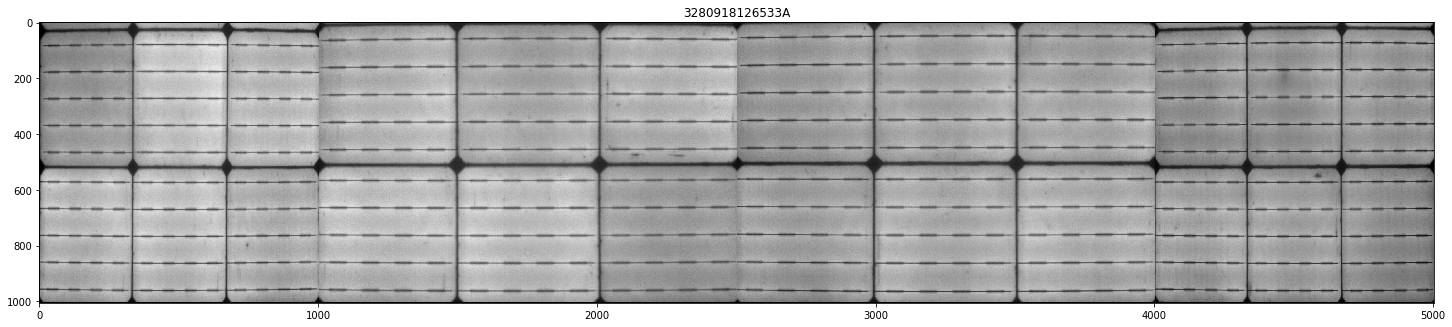

0.1376


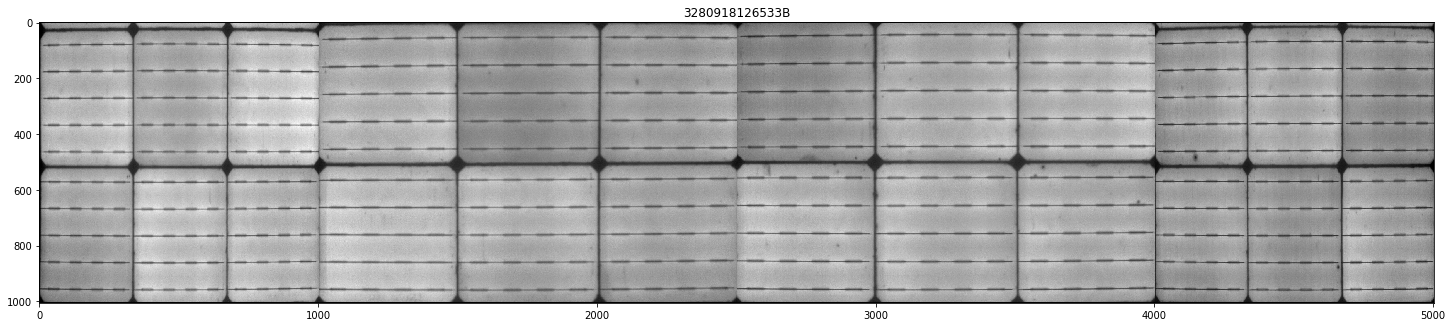

0.1466


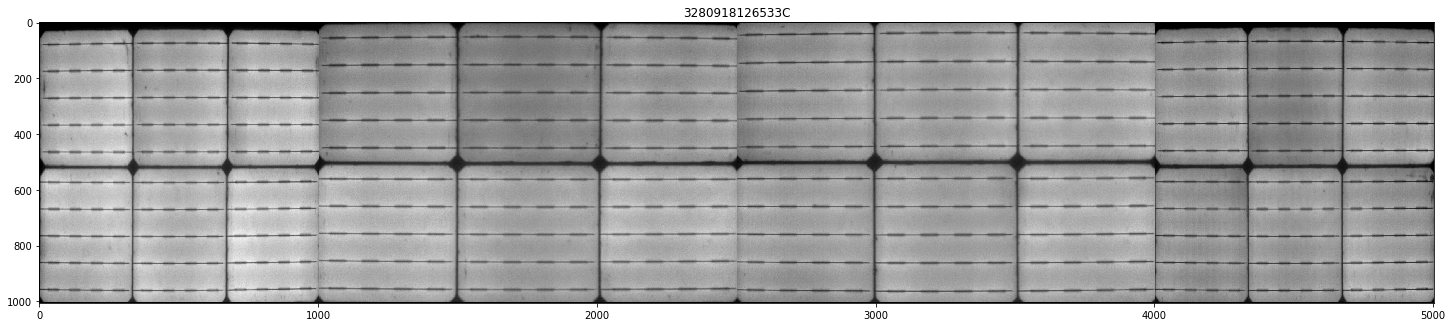

0.1935


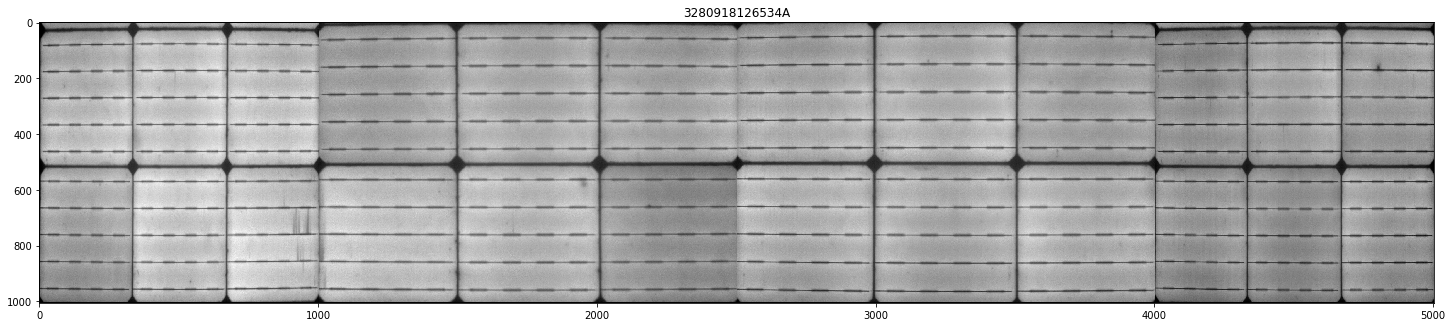

0.1516


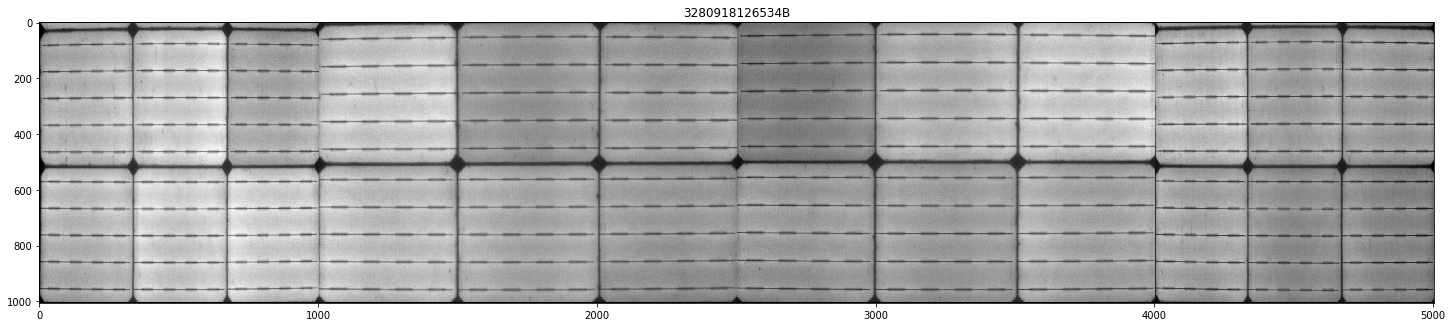

0.1366


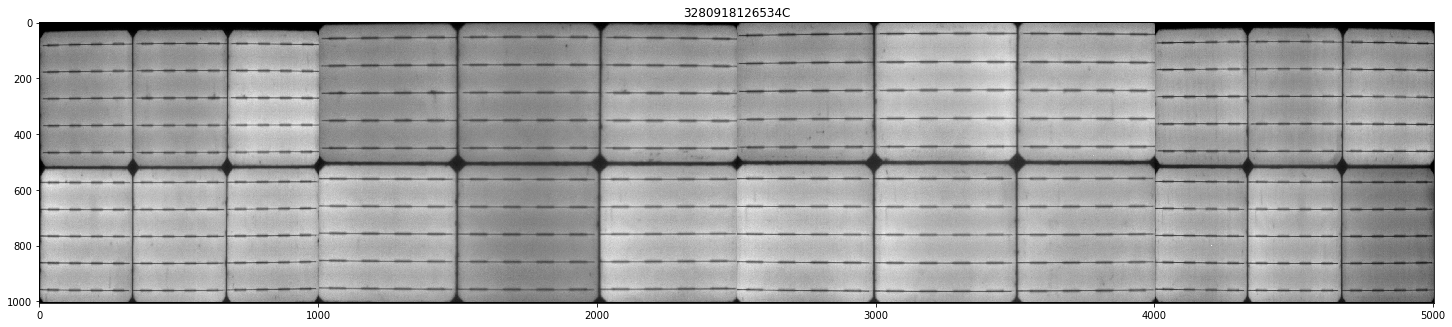

0.1775


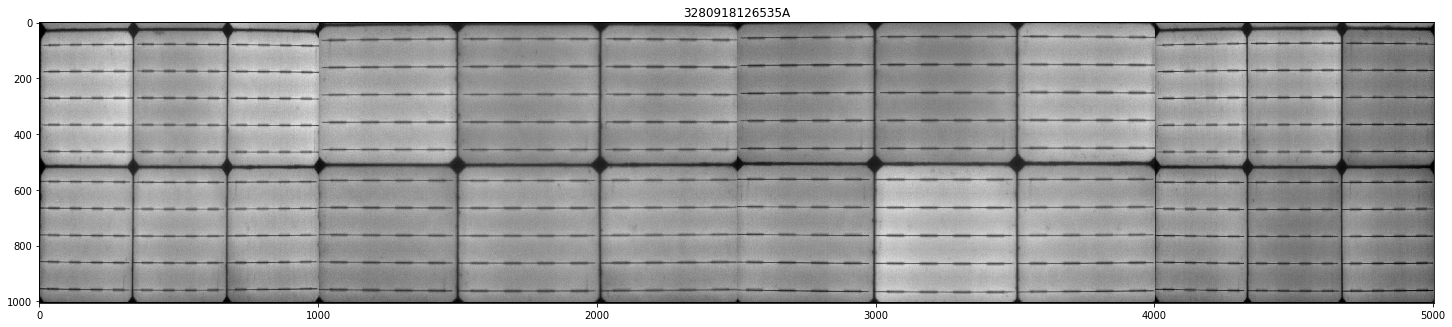

0.1336


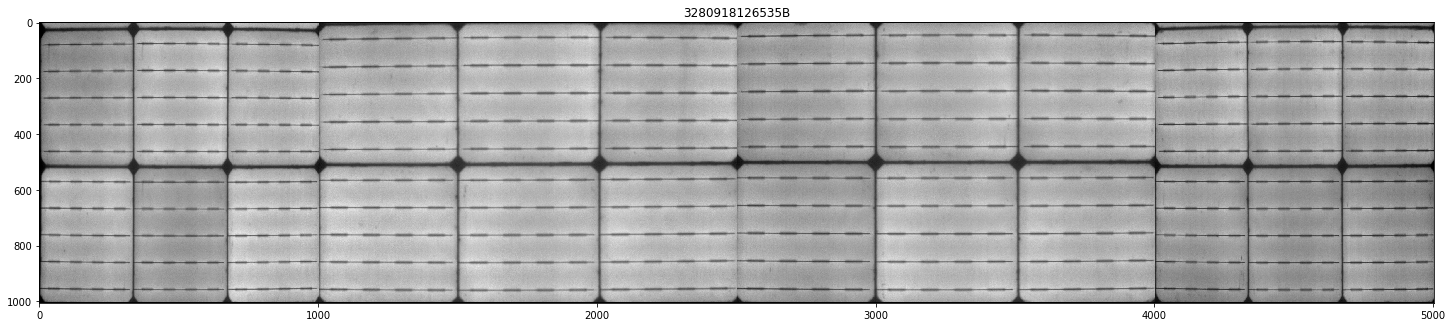

0.1297


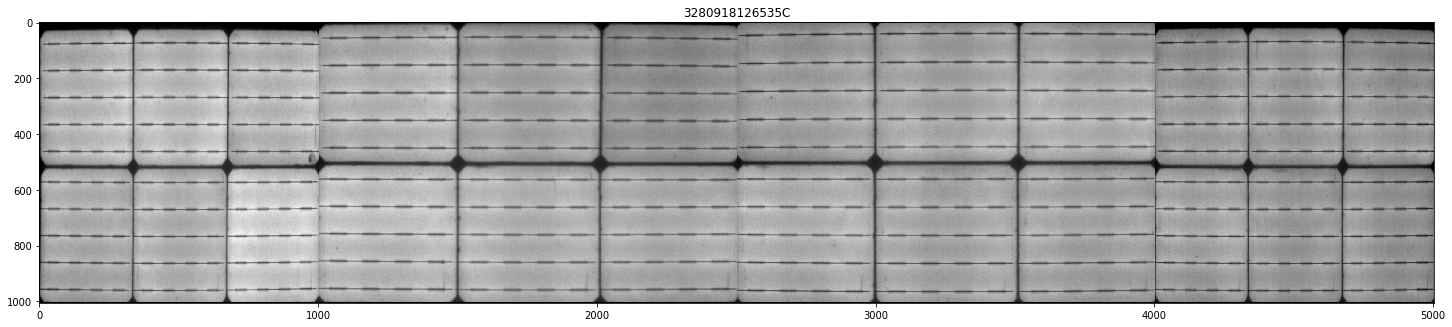

0.1407


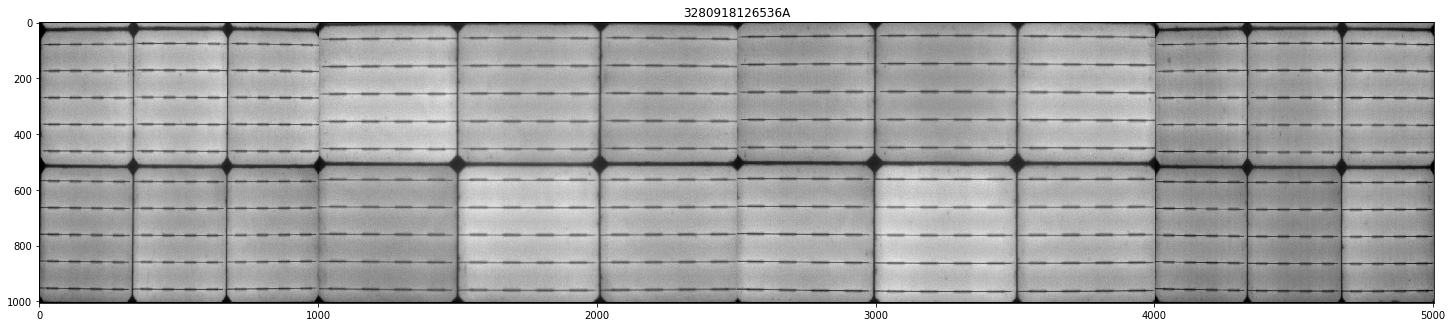

0.1416


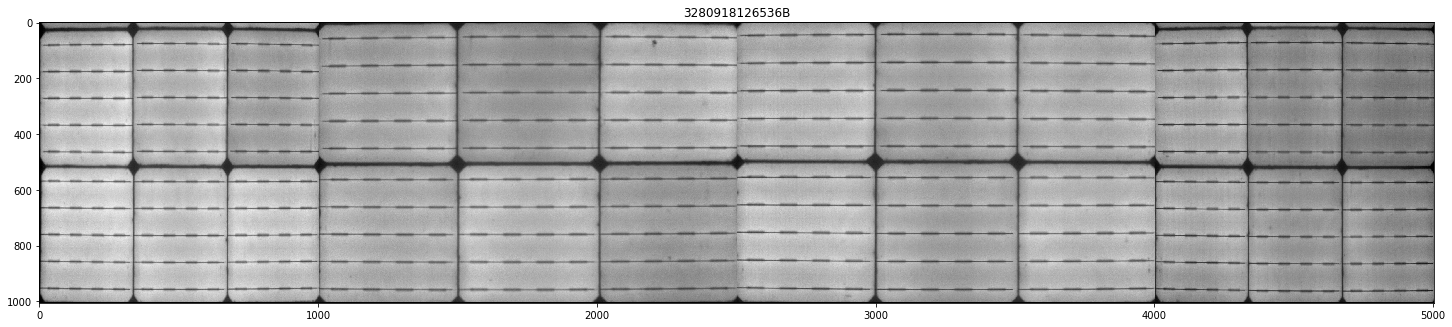

0.1306


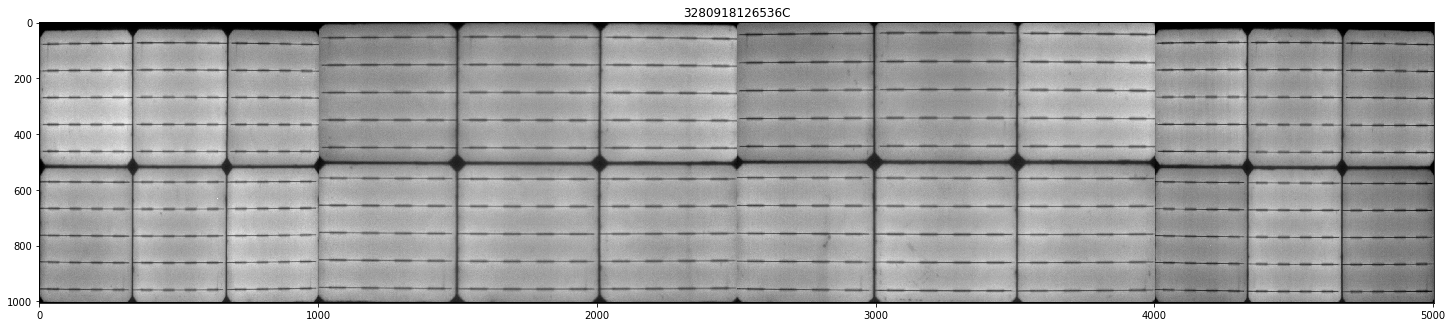

0.1287


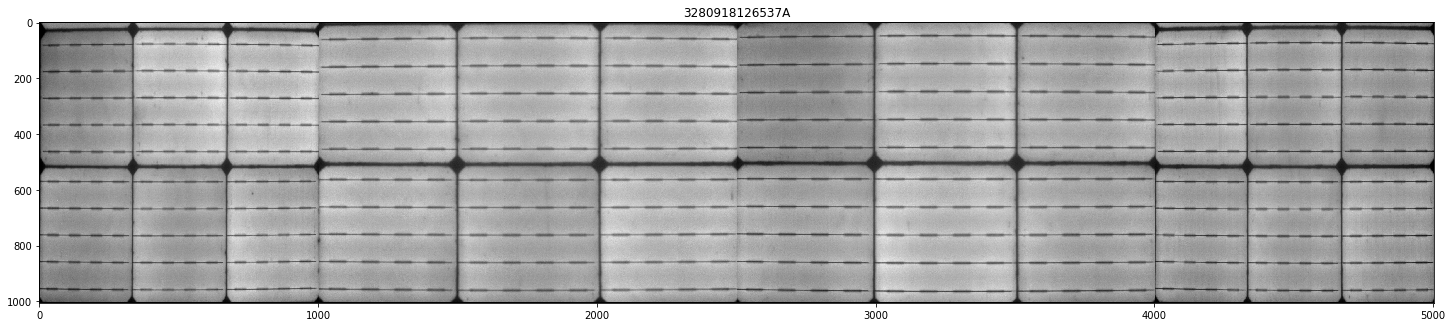

0.1307


In [ ]:
from concat_pics_longi_V1 import *
import pylab as plt
import time
plt.rc('figure', figsize = (25, 8))

for k, v in pic_dict.items():
    for s in ['A', 'B', 'C']:
        img_list = [cv2.imread(v['%s%i' % (s, i)]) for i in range(1,5)]
        tic = time.time()
        concat_4 = joint_image(img_list, s)
        toc = time.time()
        plt.title(k + s)
        plt.imshow(concat_4, 'gray')
        plt.show()
        print('%.4f' % (toc - tic))